# Fit diffusion concentration dependence from pulse test characterization data 

In [1]:
# %pip install DFO-LS -q
# need to restart jupyter server? kernal? whenever a change is made to the pybamm module? 
import sys
import os
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
sys.path.insert(0, r'c:\Users\Vivian\Dropbox (University of Michigan)\from_box\Research\PyBaMM\PyBaMM')
print(sys.path[0])
import pybamm
import dfols
from scipy.optimize import curve_fit
from scipy import integrate
from statistics import mean

# from multiprocessing import Process, Pool

# from scipy.optimize import minimize
print(pybamm.__path__[0]) # c:\Users\Vivian\Dropbox (University of Michigan)\from_box\Research\PyBaMM\PyBaMM\pybamm
%matplotlib widget


c:\Users\Vivian\Dropbox (University of Michigan)\from_box\Research\PyBaMM\PyBaMM
c:\Users\Vivian\Dropbox (University of Michigan)\from_box\Research\PyBaMM\PyBaMM\pybamm


# Load pulse testing data

In [6]:
SOC_0 = 1
SOC_name = SOC_0
Q_nom = 4.6

# load data import ESC data from file
data = pd.read_csv(
    "2C_pulse_test_data_DCR_Cell_43.csv"#, comment="#", header=None
)

# current profile for running sim
pulse_current = data[['time_s', 'I_A']].to_numpy()

# format data in dataframe 
df_labels = ['t', 'V', 'mAh', 'Temp','Q', 'I']
data.set_axis(df_labels, axis=1, inplace=True)

# calculate C-rate and SOC
data['I_C'] = data.I/Q_nom 
AhT_calculated = integrate.cumtrapz(abs(data.I), data.t-data.t.iloc[0])/3600
AhT_calculated = np.append(AhT_calculated,AhT_calculated[-1])
data['SOC'] = SOC_0 - AhT_calculated/4.2 # lower to match OCV at rest
T_amb = data.Temp.iloc[0]
data = data[np.where(data.I>1)[0][0]-1::]
data.t = data.t-data.t.iloc[0]
data.reset_index(drop=True, inplace=True)

# check data
data.head()

C:\Users\Vivian\AppData\Local\Temp\ipykernel_25720\4131281652.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data.set_axis(df_labels, axis=1, inplace=True)


,t,V,mAh,Temp,Q,I,I_C,SOC
0,0.000000,4.196351,0.000000,23.009535,2292.862303,-0.000000,-0.000000,0.997024
1,10.000000,4.102098,-24.737959,23.143507,24.737959,8.997992,1.956085,0.991074
2,20.000001,4.084767,-49.730813,23.048939,49.730813,8.997008,1.955871,0.985124
3,30.000001,4.070548,-74.723642,23.372046,74.723642,8.996023,1.955657,0.979173
4,40.000002,4.057905,-99.716322,23.639988,99.716322,8.997401,1.955957,0.973222


# Find and plot indices of pulse rest 

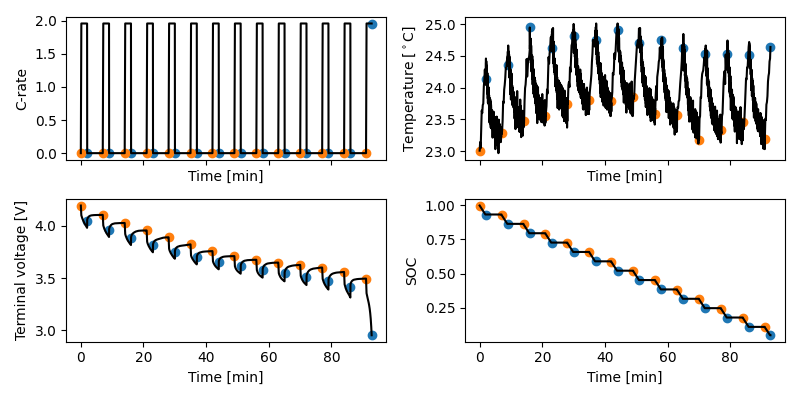

In [7]:
# find pulse indices where current changes to identify pulses 
I = data.I
pulse_current = max(I)
i1 = np.where((np.diff(I)<-0.1))[0]
i1 = i1+1
i1 = np.append(i1,len(I)-1) # indices for where rests start
i2 = np.where((np.diff(I)>0.1) & (I[1:]>pulse_current-0.1)& (I[1:]<pulse_current+0.1))[0] # indices for where pulses start

# plot start and end of pulses
fig, ax = plt.subplots(2,2, figsize=(8,4), sharex=True)
ax = ax.flatten()
linestyles = ['-','--',':','.-']*2

t = data.t/60
xlabel = "Time [min]"
data_color = 'k'
ax[0].plot(t,data.I_C, label='Data', color = data_color)
ax[0].scatter(t[i1], data.I_C[i1])
ax[0].scatter(t[i2], data.I_C[i2])
ax[0].set_xlabel(xlabel)
ax[0].set_ylabel('C-rate')

ax[2].plot(t, data.V,color = data_color)
ax[2].scatter(t[i1], data.V[i1])
ax[2].scatter(t[i2], data.V[i2])
ax[2].set_xlabel(xlabel)
ax[2].set_ylabel('Terminal voltage [V]')

ax[1].plot(t, data.Temp, color = data_color)
ax[1].scatter(t[i1], data.Temp[i1])
ax[1].scatter(t[i2], data.Temp[i2])
ax[1].set_xlabel(xlabel)
ax[1].set_ylabel('Temperature [$^\circ$C]')

ax[3].plot(t, data.SOC, color = data_color)
ax[3].scatter(t[i1], data.SOC[i1])
ax[3].scatter(t[i2], data.SOC[i2])
ax[3].set_xlabel(xlabel)
ax[3].set_ylabel('SOC')

plt.tight_layout()
plt.show()


In [8]:
def plot_pulse(data, solutions, labels = []):
    fig, ax = plt.subplots(2,2, figsize=(8,4), sharex=True)
    ax = ax.flatten()

    t = data.t/60
    xlabel = "Time [min]"
    data_color = 'k'
    ax[0].plot(t,data.I_C, label='Data', color = data_color)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('C-rate')


    ax[2].plot(t, data.V,color = data_color)
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel('Terminal voltage [V]')

    ax[1].plot(t, data.Temp, color = data_color)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Temperature [$^\circ$C]')

    ax[3].plot(t, data.SOC, color = data_color)
    ax[3].set_xlabel(xlabel)
    ax[3].set_ylabel('SOC')

    sim_colors = ['r','g','b','m']*2
    for i,solution in enumerate(solutions):
        t = solution["Time [s]"].entries
        x = solution["x [m]"].entries[:, 0]
        I = solution['C-rate']
        V = solution['Terminal voltage [V]']
        T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
        soc = solution['R-averaged negative particle concentration']

        x_plot = t/60
        ax[0].plot(x_plot, I(t), linestyle=':',color = sim_colors[i])
        ax[2].plot(x_plot, V(t), linestyle=':',color = sim_colors[i])
        ax[1].plot(x_plot, T,linestyle=':',color = sim_colors[i])  # can evaluate at arbitrary x (single representative particle)
        ax[3].plot(x_plot, soc(t=t, x=x[-1]),linestyle=':',color = sim_colors[i])  # can evaluate at arbitrary x (single representative particle)


    plt.tight_layout()
    plt.show()


# Set up nominal model

2023-08-01 14:07:27.431 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


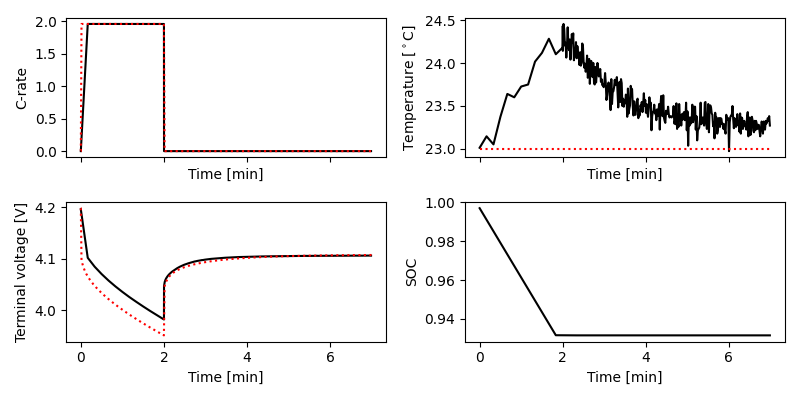

In [9]:
# set up pulse data
pulse = data[i2[0]:i2[1]].copy()
pulse.t = pulse.t-pulse.t.iloc[0]

# define parameters for simulation
SOC_0 = pulse.SOC.iloc[0]
pulse_current = pulse[['t','I']].to_numpy()

# set up and solve model
solutions = []
model = pybamm.lithium_ion.SPMe() # isothermal
param = pybamm.ParameterValues(pybamm.parameter_sets.Mohtat2020)
param.update({
    "Lower voltage cut-off [V]": 0,
    "Nominal cell capacity [A.h]": 4.6,
    "Typical current [A]":4.6,
    "Negative tab width [m]":2.5e-2,
    "Positive tab width [m]":2.5e-2,
    "Negative electrode thickness [m]":62E-06*4.2/5,
    "Positive electrode thickness [m]":67E-06*4.2/5,
    "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": 5,  
    "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": 5,  
    "Negative tab heat transfer coefficient [W.m-2.K-1]":5,  
    "Positive tab heat transfer coefficient [W.m-2.K-1]":5,  
    "Edge heat transfer coefficient [W.m-2.K-1]":5,
    "Total heat transfer coefficient [W.m-2.K-1]":5,
    "Negative electrode diffusivity [m2.s-1]": 8.0E-14, 
    "Positive electrode diffusivity [m2.s-1]": 8.0E-15, 
    "Ambient temperature [K]": 23+273.15,
    "Initial temperature [K]": 23 + 273.15,

}, check_already_exists = False)

# programming the pulse is faster to run than using input current. data also at 0.1Hz...
experiment = pybamm.Experiment( 
        # [
        # "Run pulse (A) until 3.0 V"
        # ],
        [
        ("Rest for 0.00001 minutes",
        "Discharge at 1.956 C for 2 minutes or until 2.8 V", 
        "Rest for 5 minutes",) 

        ],
        drive_cycles={
            'pulse': pulse_current
        }
        , period = "1 second"
    )
sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
solution = sim.solve( initial_soc=SOC_0)
solutions.append(solution)

# plot simulation results 
plot_pulse(pulse,solutions)

# Set up loss function for parameterization

In [11]:
# # run simulation with input k to scale D and output error metric
# # Input and output are np.array

def rmse(y):
    return np.sqrt(np.mean(np.square(y)))

def simulate_pulse(k:np.ndarray): 
    Dp_0 = 8.0E-15
    Dn_0 = 8.0E-14

    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*k[0],
        "Negative electrode diffusivity [m2.s-1]": Dn_0*k[1],
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve(initial_soc=SOC_0)
    
    # calculate rmse for rest period
    V = solution['Terminal voltage [V]']
    t_error = pulse.t[pulse.I ==0].to_numpy() #
    rmse_V = np.sum(np.square(pulse.V[pulse.I ==0]- V(t_error)))
    # rmse_V = rmse(pulse.V[pulse.I ==0]- V(t_error))
    return np.array([rmse_V])
    
def simulate_pulse_rmse(k:np.ndarray): 
    Dp_0 = 8.0E-15
    Dn_0 = 8.0E-14

    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*k[0],
        "Negative electrode diffusivity [m2.s-1]": Dn_0*k[1],
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve(initial_soc=SOC_0)
    
    # calculate rmse for rest period
    V = solution['Terminal voltage [V]']
    t_error = pulse.t[pulse.I ==0].to_numpy() #
    rmse_V = rmse(pulse.V[pulse.I ==0]- V(t_error))
    return np.array([rmse_V])


# test function (0.00880287)
print(simulate_pulse(np.array([1,1])))

[0.00880287]


# Fit all pulses (p and n simultaneously)

0


2023-08-01 14:08:12.566 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:08:12.712 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


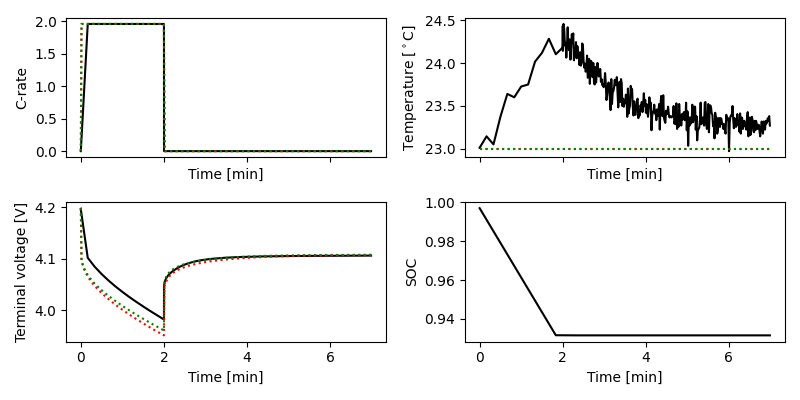

1


2023-08-01 14:08:31.931 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:08:32.115 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


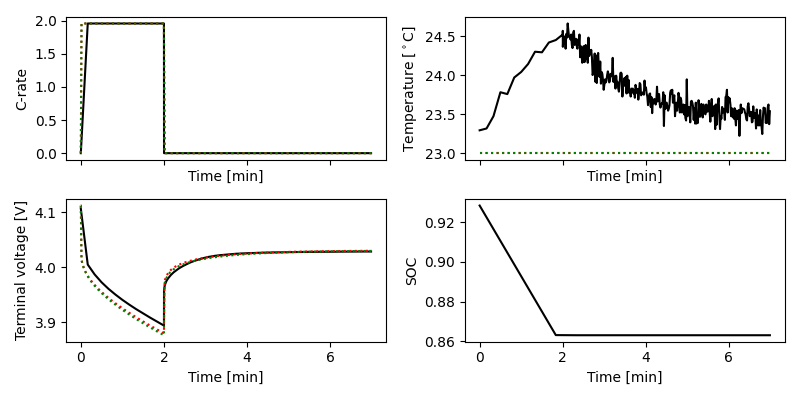

2


2023-08-01 14:08:52.676 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:08:52.812 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


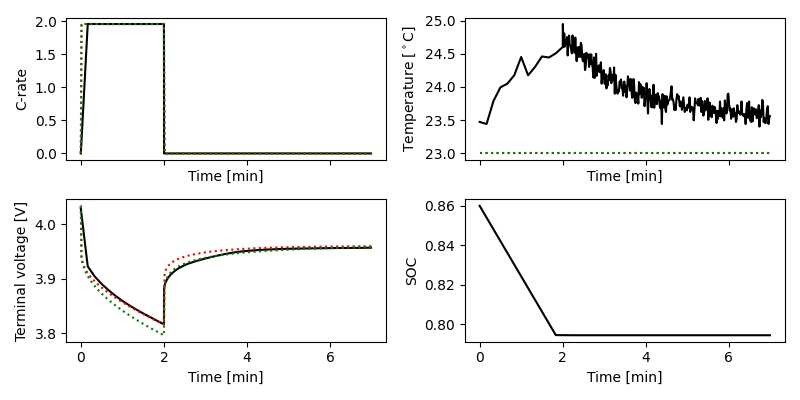

3


2023-08-01 14:09:14.139 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:09:14.268 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


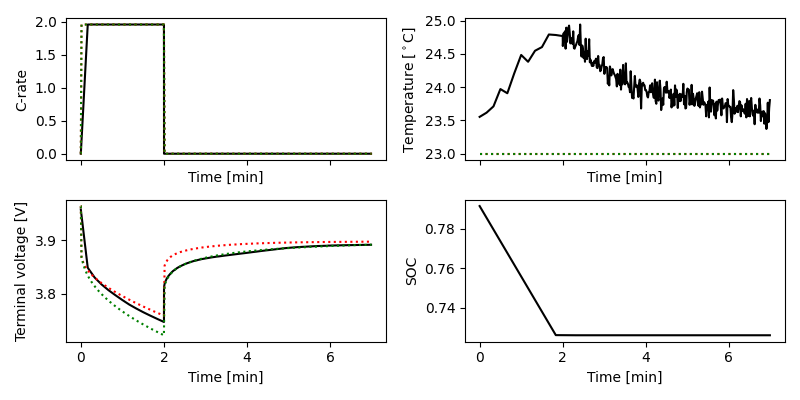

4


2023-08-01 14:09:40.744 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:09:40.878 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


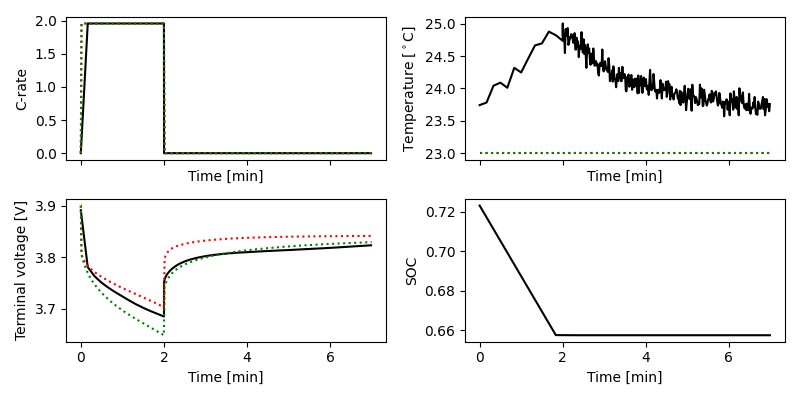

5


2023-08-01 14:10:25.292 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:10:25.482 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


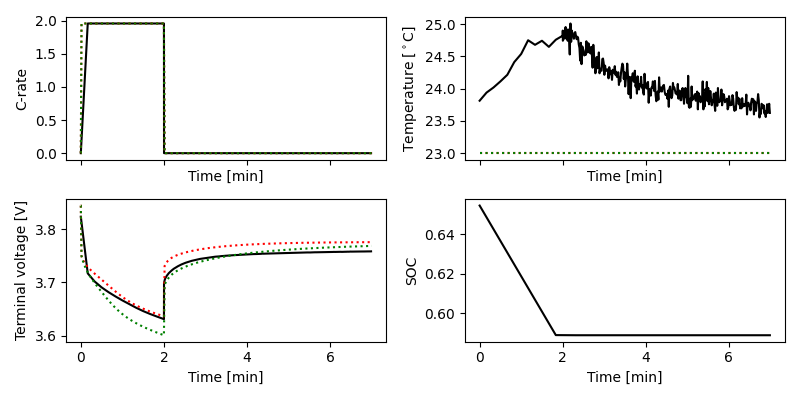

6


2023-08-01 14:10:52.228 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:10:52.401 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


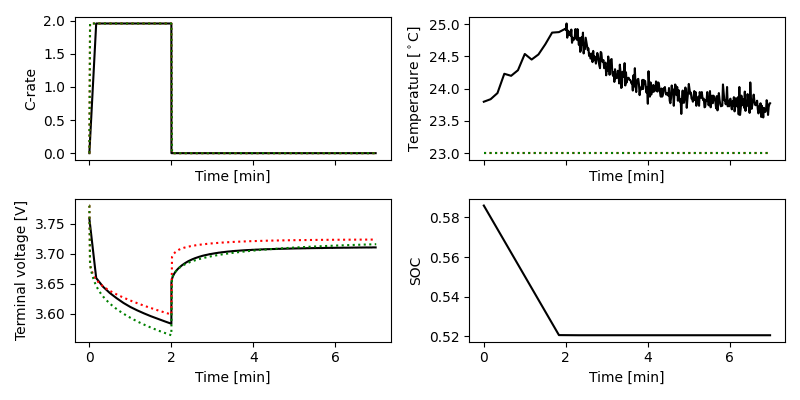

7


2023-08-01 14:11:27.798 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:11:27.934 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


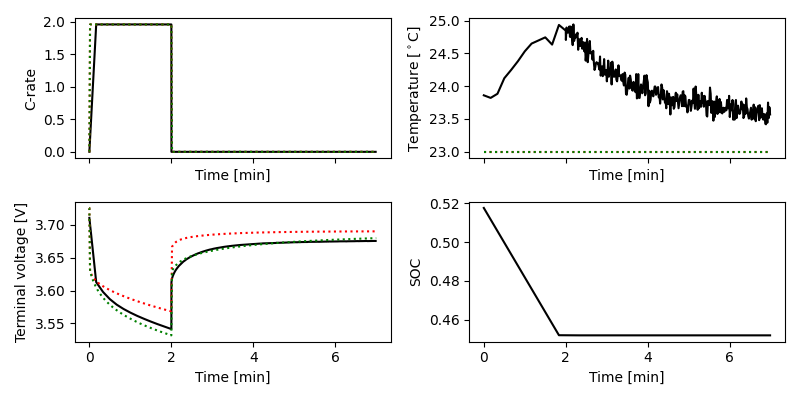

8


2023-08-01 14:12:12.279 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:12:12.401 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


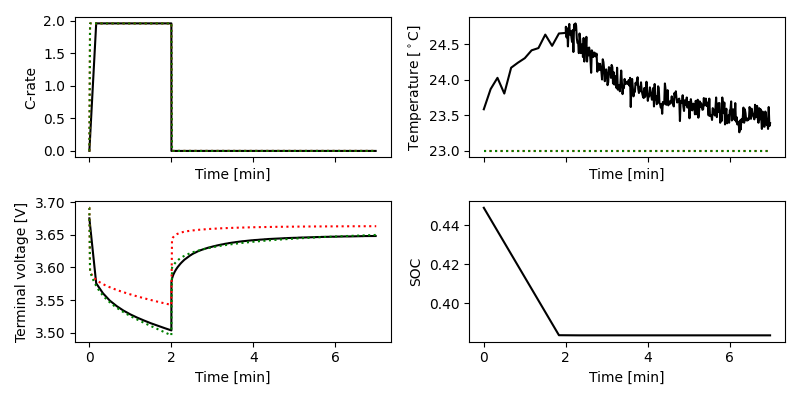

9


2023-08-01 14:12:33.600 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:12:33.733 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


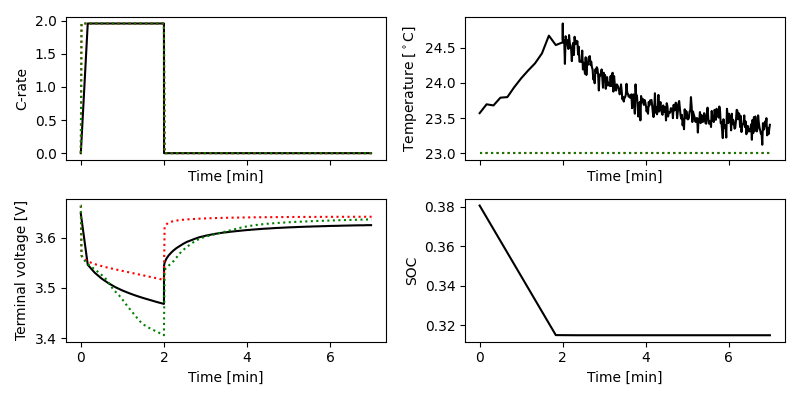

10


2023-08-01 14:12:58.535 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:12:58.662 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


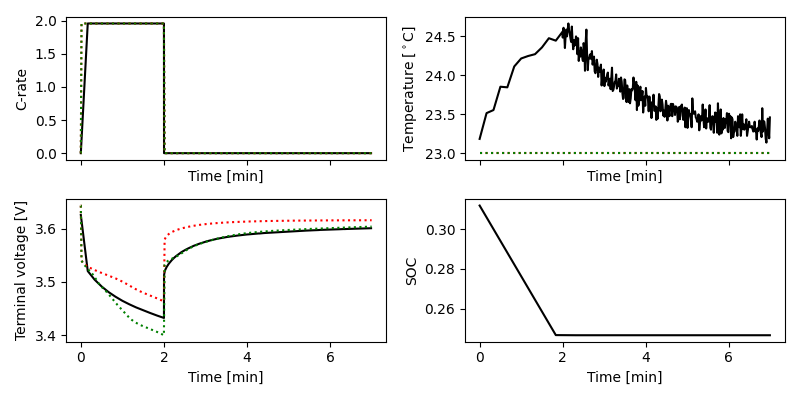

11


2023-08-01 14:13:42.878 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:13:43.029 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


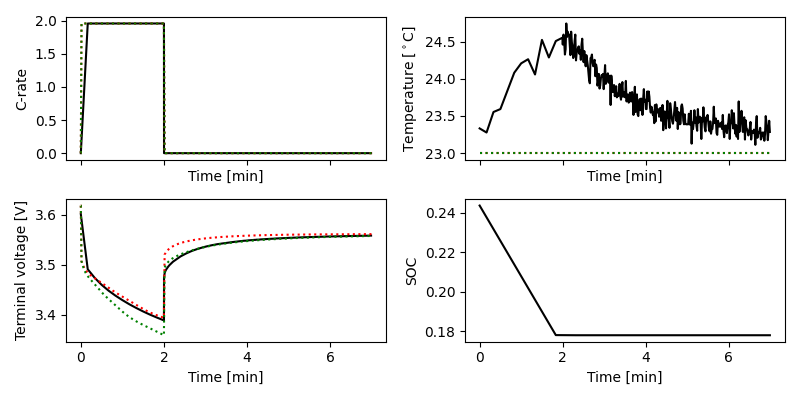

12


2023-08-01 14:13:50.539 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:14:09.111 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 14:14:09.235 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


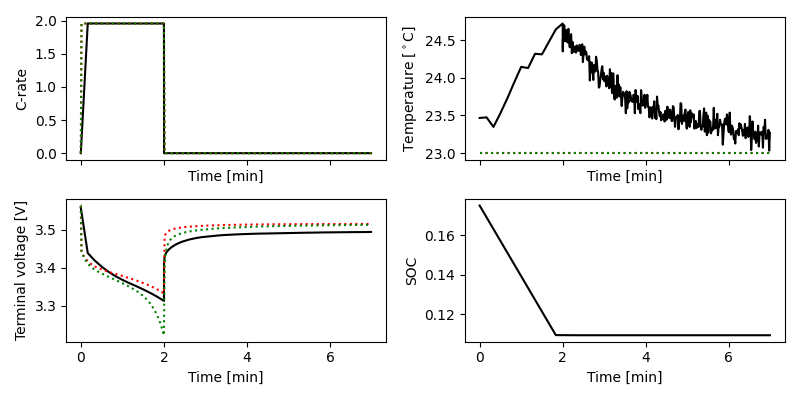

In [12]:
Dp_0 = 8.0E-15
Dn_0 = 8.0E-14
lb = np.array([0.1]*2)
ub =  np.array([10]*2)
k_list = []                               
SOC_list = []
e_list = []
models = []
for c,(i,j) in enumerate(zip(i2[0:-1],i2[1::])):
    print(c)
    # define pulse data
    pulse = data[i:j].copy()
    pulse.t = pulse.t-pulse.t.iloc[0]

    # define sim parameters
    SOC_0 = pulse.SOC.iloc[0]
    pulse_current = pulse[['t','I']].to_numpy()

    # define model 
    # if c ==0:
    model = pybamm.lithium_ion.SPMe()
    # else: 
    #     model.set_initial_conditions_from(solution, inplace=True)
        
    # Fit D
    k0 = np.array([1]*2)
    loss_function = simulate_pulse
    k = dfols.solve(simulate_pulse, k0, bounds = (lb,ub), rhoend=1e-2) # fix pos, fit neg

    e = loss_function(k.x)

    k_list.append(k.x)
    SOC_list.append(pulse.SOC.iloc[-1])  
    e_list.append(e)

    # simulate and plot nominal and fitted results for comparison
    solutions = []
    # simulate with nominal Dp, Dn
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0,
        "Negative electrode diffusivity [m2.s-1]": Dn_0,
        })
    sim0 = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution0 = sim0.solve( initial_soc=SOC_0)
    solutions.append(solution0)
    
    # simulate with fitted Dp, Dn
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*k_list[c][0],
        "Negative electrode diffusivity [m2.s-1]": Dn_0*k_list[c][1],
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve( initial_soc=SOC_0)
    solutions.append(solution)

    # plot both simulations
    plot_pulse(pulse,solutions)

In [14]:
# save parameters and soc 
Ds = pd.DataFrame(columns=('SOC', 'kp','kn','e'))
for i,(k, soc, e) in enumerate(zip(k_list, SOC_list, e_list)):
   if  (k[0]) and (k[1]):
      Ds.loc[i] = [soc, k[0], k[1], e[0]]

display(Ds)
Ds.to_csv('Ds_restart_squaredsum_11_simultaneous_rest.csv')

,SOC,kp,kn,e
0,0.931499,1.234987,0.998734,0.005557
1,0.862995,0.919249,0.935013,0.005682
2,0.794493,0.636273,1.101516,0.005893
3,0.725995,0.418403,0.960937,0.006290
4,0.657494,0.251229,1.007850,0.018854
5,0.588994,0.326673,0.771173,0.020551
6,0.520495,0.268135,0.826387,0.008484
7,0.451993,0.182189,9.859242,0.006616
8,0.383496,0.111388,9.862885,0.007361
9,0.314995,0.329631,0.100000,0.045090


# Fit concentration dependence

## Polyfit concentration dependence

In [15]:
def polystr(pk):    
    label = []
    for i, p in enumerate(pk):
        #coeff
        label.append(str(round(p,3)))

        # x^n
        if len(pk)-i-1>1:
            label.append('$x^' + str(len(pk)-i-1) + '$' + ' + ')
        elif i== len(pk)-2:
            label.append('$x$'  + ' + ')

    return ''.join(label)

In [16]:
Ds0 = pd.read_csv('Ds_restart_squaredsum_11_simultaneous_rest.csv', usecols=range(1,5)) #, sep = '\t'
display(Ds0)

,SOC,kp,kn,e
0,0.931499,1.234987,0.998734,0.005557
1,0.862995,0.919249,0.935013,0.005682
2,0.794493,0.636273,1.101516,0.005893
3,0.725995,0.418403,0.960937,0.006290
4,0.657494,0.251229,1.007850,0.018854
5,0.588994,0.326673,0.771173,0.020551
6,0.520495,0.268135,0.826387,0.008484
7,0.451993,0.182189,9.859242,0.006616
8,0.383496,0.111388,9.862885,0.007361
9,0.314995,0.329631,0.100000,0.045090


In [81]:
# # plot error outlier
# import seaborn as sns
# print(sum(Ds.e.loc[Ds.e<0.1])/len(Ds.e.loc[Ds.e<0.1])) 
# fig, ax = plt.subplots(1,1, figsize=(8,4), sharex=True)
# # ax = ax.flatten()
# sns.boxplot(Ds.e, whis=3)
# plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[ 4.7302281  -4.5023245   1.26466141]
[1.12070451 0.09209274]


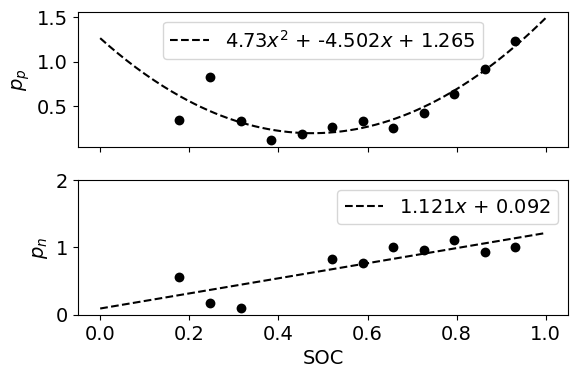

In [18]:
%matplotlib inline
# load values
Ds = Ds0.copy()
Ds = Ds0[(Ds0.e<0.1)]
# Ds.kn[Ds0.kn>5] =1
# Ds.kp[Ds0.kp>5] =1
# Ds = Ds0.loc[(Ds0.kn<5) & (Ds0.kp<5)]

# polyfit data
# pp = np.polyfit(Ds.SOC.loc[(Ds.kp<9) & (Ds.kp>0.1) & (Ds0.e<0.1) & (Ds0.e>0.0001)], Ds.kp.loc[(Ds.kp<9) & (Ds.kp>0.1) & (Ds0.e<0.1) & (Ds0.e>0.0001)],2) 
# pn = np.polyfit(Ds.SOC.loc[(Ds.kn<9) & (Ds.kn>0.1)& (Ds0.e<0.1) & (Ds0.e>0.0001)], Ds.kn.loc[(Ds.kn<9) & (Ds.kn>0.1)& (Ds0.e<0.1) & (Ds0.e>0.0001) ],1) 
pp = np.polyfit(Ds.SOC, Ds.kp,2) 
pn = np.polyfit(Ds.SOC.loc[(Ds.kn<9)], Ds.kn.loc[(Ds.kn<9)],1) 
# pn = np.polyfit(Ds.SOC, Ds.kn,1) 
x = np.linspace(0,1,200)
yp = np.polyval(pp,x)
yn = np.polyval(pn,x)

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Ds.SOC, Ds.kp, color = 'lightgrey')
ax[0].scatter(Ds.SOC.loc[(Ds.kp<9) & (Ds.kp>0.1) & (Ds0.e<0.1) & (Ds0.e>0.0001)], Ds.kp.loc[(Ds.kp<9) & (Ds.kp>0.1) & (Ds0.e<0.1) & (Ds0.e>0.0001)], color = 'k')
ax[0].plot(x, yp, color = 'k', label = polystr(pp) , linestyle = '--')#,
ax[0].set_ylabel('$p_p$')
ax[0].legend(loc = "upper center", prop={'size': 14})
# ax[0].set_ylim([0,2])
ax[1].scatter(Ds.SOC, Ds.kn , color = 'lightgrey') 
# ax[1].scatter(Ds.SOC.loc[(Ds.kn<9) & (Ds.kn>0.1) & (Ds0.e<0.1) & (Ds0.e>0.0001)], Ds.kn.loc[(Ds.kn<9) & (Ds.kn>0.1) & (Ds0.e<0.1) & (Ds0.e>0.0001)] , color = 'k') 
ax[1].scatter(Ds.SOC.loc[(Ds.kn<9)], Ds.kn.loc[(Ds.kn<9)], color = 'k') 

ax[1].plot(x, yn, color = 'k', label = polystr(pn), linestyle = '--')#
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$p_n$')
ax[1].set_ylim([0,2])
ax[1].legend( prop={'size': 14}) #loc = "upper center",

print(pp)
print(pn)

plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.savefig('./figs/p.eps', format='eps')
plt.show()

# Archive

## Fit single pulse and save 

In [ ]:
k_list = []     
k0_list = []                               
SOC_list = []
e_list = []

In [72]:
pulse_num=12

In [80]:
def simulate_pulse(k:np.ndarray): 
    Dp_0 = 8.0E-15
    Dn_0 = 8.0E-14

    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*k[0],
        "Negative electrode diffusivity [m2.s-1]": Dn_0*k[1],
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve(initial_soc=SOC_0)
    
    # calculate rmse for rest period
    V = solution['Terminal voltage [V]']
    t_error = pulse.t.to_numpy()
    rmse_V = np.sum(np.square(pulse.V- V(t_error)))

    return np.array([rmse_V])
    

# test function
print(simulate_pulse(np.array([1,1])))

[0.23046226]


2023-07-22 20:44:10.639 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-22 20:44:13.741 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-22 20:44:27.702 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-07-22 20:44:27.868 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


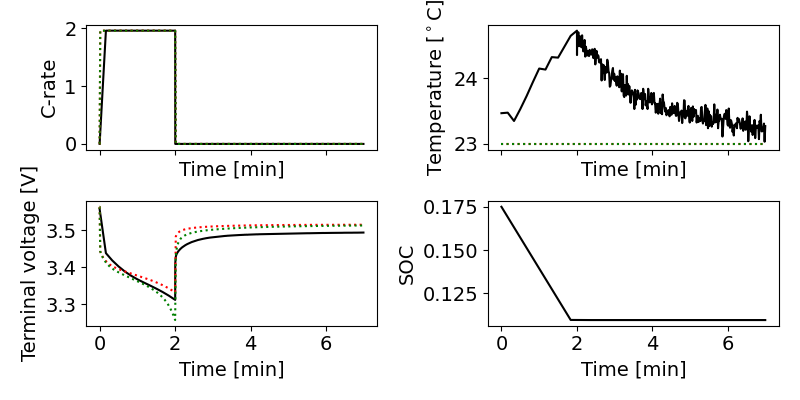

****** DFO-LS Results ******
Solution xmin = [0.4339103  0.93233564]
Residual vector = [0.14495309]
Objective value f(xmin) = 0.02101139783
Needed 17 objective evaluations (at 17 points)
Approximate Jacobian = [[ 0.11449914 -0.03460601]]
Exit flag = 0
Success: rho has reached rhoend
****************************

[0.14495309]


In [81]:
Dp_0 = 8.0E-15
Dn_0 = 8.0E-14
lb = np.array([1e-1]*2)
ub = np.array([1e1]*2)

for i,j in zip(i2[pulse_num:pulse_num+1],i2[pulse_num+1:pulse_num+2]):

    # define pulse data
    pulse = data[i:j].copy()
    pulse.t = pulse.t-pulse.t.iloc[0]

    # define sim parameters
    SOC_0 = pulse.SOC.iloc[0]
    pulse_current = pulse[['t','I']].to_numpy()

    model = pybamm.lithium_ion.SPMe()

    solutions = []
    # simulate nominal
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0,
        "Negative electrode diffusivity [m2.s-1]": Dn_0,
        # "Negative electrode thickness [m]":62E-06*4.2/5,
        # "Positive electrode thickness [m]":67E-06*4.2/5,
        # "Typical electrolyte diffusivity [m2.s-1]":5.35E-10,
        # "Typical electrolyte conductivity [m2.s-1]":1.3,
        })
    sim0 = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution0 = sim0.solve( initial_soc=SOC_0)
    solutions.append(solution0)
    
    # fit k
    k0 = np.array([1]*2)
    loss_function = simulate_pulse
    # k0 = np.array([SOC_0])   
    # kp = dfols.solve(simulate_pulse_pos, k0, args=(np.array([1])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-3) # fix pos, fit neg
    k = dfols.solve(simulate_pulse, k0, bounds = (lb,ub), rhoend=1e-2) # fix pos, fit neg
    e = loss_function(k.x)    # fitted
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*k.x[0],
        # "Positive electrode diffusivity [m2.s-1]": Dp_0*0.475311,
        # "Negative electrode diffusivity [m2.s-1]": Dn_0,
        "Negative electrode diffusivity [m2.s-1]": Dn_0*k.x[1],
        # "Typical electrolyte diffusivity [m2.s-1]":5.35E-10,
        # "Typical electrolyte conductivity [m2.s-1]":1.3,
        })
        
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve( initial_soc=SOC_0)
    solutions.append(solution)

    # plot with 
    plot_pulse(pulse,solutions)

print(k.x)
print(e)

In [ ]:
# k_list.append(k.x[:])
# k0_list.append(k0)
# SOC_list.append(pulse.SOC.iloc[-1])  
# e_list.append(simulate_pulse(k.x))

In [ ]:
# save parameters and soc 
Ds = pd.DataFrame(columns=('SOC', 'kp','kn','e', 'k0'))
for i,(k, soc, e, k0) in enumerate(zip(k_list, SOC_list, e_list, k0_list)):
   Ds.loc[i] = [soc, k[0], k[1],e[0], k0[:]]

display(Ds)
# Ds.to_csv('./fast_discharge/Ds8_rmse_V.csv',sep='\t')

,SOC,kp,kn,e,k0
0,0.428726,0.218644,1.191671,0.004071,"[0.50013484047955, 1.0]"


## Define alternative loss functions (separate Dn and Dp fitting)

In [17]:

def simulate_pulse_pos(kp:np.ndarray, kn): 
    Dp_0 = 8.0E-15
    Dn_0 = 8.0E-14

    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*kp[0],
        "Negative electrode diffusivity [m2.s-1]": Dn_0*kn,
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve(initial_soc=SOC_0)
    
    # calculate rmse for rest period
    V = solution['Terminal voltage [V]']
    # t_error = pulse.t[(pulse.V > 3.0)].to_numpy() #  & (pulse.I ==0)
    # rmse_V = np.sqrt(np.mean(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error))))
    # # rmse_V = np.sum(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error)))
    # rmse_dV = np.sqrt(np.mean(np.square(np.diff(pulse.V[(pulse.V > 3.0)])- np.diff(V(t_error)))))
    # # rmse_V = np.sum(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error)))
    t_error = pulse.t[(pulse.I ==0)].to_numpy() #  & (pulse.I ==0)
    rmse_V = np.sqrt(np.mean(np.square(pulse.V[(pulse.I ==0)]- V(t_error))))
    return np.array([rmse_V])

def simulate_pulse_neg(kn:np.ndarray, kp): 
    Dp_0 = 8.0E-15
    Dn_0 = 8.0E-14

    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*kp,
        "Negative electrode diffusivity [m2.s-1]": Dn_0*kn[0],
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve(initial_soc=SOC_0)
    
    # calculate rmse for rest period
    V = solution['Terminal voltage [V]']
    t_error = pulse.t[(pulse.I ==0)].to_numpy() #  & (pulse.I ==0)
    rmse_V = np.sqrt(np.mean(np.square(pulse.V[(pulse.I ==0)]- V(t_error))))
    # rmse_V = np.sum(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error)))
    # rmse_dV = np.sqrt(np.mean(np.square(np.diff(pulse.V[(pulse.V > 3.0)& (pulse.I ==0)])- np.diff(V(t_error)))))
    # rmse_V = np.sum(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error)))

    return np.array([rmse_V])




# run simulation with input k to scale D and output error metric
# Input and output are np.array
def simulate_pulse_dV(k:np.ndarray): 
    Dp_0 = 8.0E-15
    Dn_0 = 8.0E-14

    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*k[0],
        "Negative electrode diffusivity [m2.s-1]": Dn_0*k[1],
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve(initial_soc=SOC_0)
    
    # calculate rmse for rest period
    V = solution['Terminal voltage [V]']
    t_error = pulse.t[(pulse.V > 3.0)].to_numpy() #  & (pulse.I ==0)
    # rmse_V = np.sqrt(np.mean(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error))))
    # rmse_V = np.sum(np.square(pulse.V[(pulse.V > 3.0)]- V(t_error)))
    e_dV = np.sum(np.diff(pulse.V[pulse.V > 3.0])- np.diff(V(t_error)))

    return np.array([e_dV])

# test function
print(simulate_pulse_pos(np.array([1]), 1))
print(simulate_pulse_neg(np.array([1]), 1))

[0.0054079]
[0.0054079]


## Sensitivity to Dp and Dn

In [18]:
rmses_V_Dp = []
rmses_V_Dn = []
rmses_nom = []
SOCs_0 = []
for c,(i,j) in enumerate(zip(i2[0:-1],i2[1::])):
    print(c)
    # set up pulse data
    pulse = data[i:j]
    pulse.t = pulse.t-pulse.t.iloc[0]

    # define parameters for simulation
    SOC_0 = pulse.SOC.iloc[0]
    pulse_current = pulse[['t','I']].to_numpy()

    # calculate rmses
    rmse_nom = simulate_pulse_pos(np.array([1]), 1)[0]
    Dp_up = simulate_pulse_pos(np.array([1.1]), 1)[0]
    Dp_down = simulate_pulse_pos(np.array([0.9]), 1)[0]
    Dn_up = simulate_pulse_neg(np.array([1.1]), 1)[0]
    Dn_down = simulate_pulse_neg(np.array([0.9]), 1)[0]

    # save
    rmses_nom.append(rmse_nom)
    rmses_V_Dp.append((abs(Dp_up - Dp_down)))
    rmses_V_Dn.append((abs(Dn_up - Dn_down)))
    SOCs_0.append(SOC_0)

diff_rmses_V_D = [dp-dn for (dp,dn) in zip(rmses_V_Dp, rmses_V_Dn)]
rel_rmses_V_Dp = [d/nom for (d,nom) in zip(rmses_V_Dp, rmses_nom)]
rel_rmses_V_Dn = [d/nom for (d,nom) in zip(rmses_V_Dn, rmses_nom)]

sensitivity_rmses = pd.DataFrame({'SOC': SOCs_0, 'delta_rmses_V_Dp': rmses_V_Dp, 'delta_rmses_V_Dn': rmses_V_Dn, 'rmses_nom': rmses_nom, 'diff_rmses_V_D': diff_rmses_V_D, 'rel_delta_rmses_V_Dp': rel_rmses_V_Dp, 'rel_delta_rmses_V_Dn': rel_rmses_V_Dn,})
display(sensitivity_rmses)


0
1
2
3
4
5
6
7
8
9
10
11
12


,SOC,delta_rmses_V_Dp,delta_rmses_V_Dn,rmses_nom,diff_rmses_V_D,rel_delta_rmses_V_Dp,rel_delta_rmses_V_Dn
0,0.997024,0.002101,5.232720e-06,0.005408,0.002096,0.388594,0.000968
1,0.928524,0.000766,1.886397e-06,0.004534,0.000764,0.168952,0.000416
2,0.860020,0.002460,2.182130e-07,0.008845,0.002459,0.278078,0.000025
3,0.791518,0.002381,5.171662e-07,0.016455,0.002380,0.144681,0.000031
4,0.723020,0.001930,1.046763e-04,0.027526,0.001826,0.070125,0.003803
5,0.654518,0.001495,6.987061e-04,0.018809,0.000796,0.079472,0.037147
6,0.586019,0.001370,4.692124e-06,0.016842,0.001365,0.081317,0.000279
7,0.517520,0.001138,1.056215e-07,0.020460,0.001138,0.055612,0.000005
8,0.449018,0.000922,5.863263e-07,0.024306,0.000921,0.037913,0.000024
9,0.380521,0.000752,1.226102e-04,0.030080,0.000630,0.025016,0.004076


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


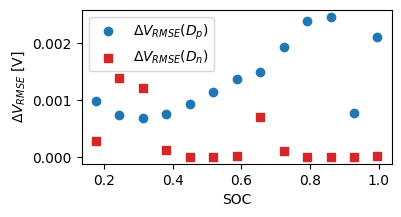

In [26]:
%matplotlib inline
# plot sensitivities vs pulse number
fig, ax1 = plt.subplots(1,1, figsize=(4,2), sharex=True)
x = list(sensitivity_rmses.SOC)

color = 'tab:blue'
ax1.set_xlabel('SOC')
ax1.set_ylabel("$\Delta V_{RMSE}$ [V]")
ax1.scatter(x, sensitivity_rmses['delta_rmses_V_Dp'], color=color, label = "$\Delta V_{RMSE}(D_p)$")
# ax1.tick_params(axis='y', labelcolor=color)
color = 'tab:red'
ax1.scatter(x, sensitivity_rmses['delta_rmses_V_Dn'], color=color, marker = "s", label = "$\Delta V_{RMSE}(D_n)$")
ax1.legend()

plt.tight_layout
plt.show
# plt.title('$|V_{RMSE}(1.1D_k) - V_{RMSE}(0.9D_k))|$')
plt.savefig('./fast_discharge/figs/Ds_sensitivity.eps', format='eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


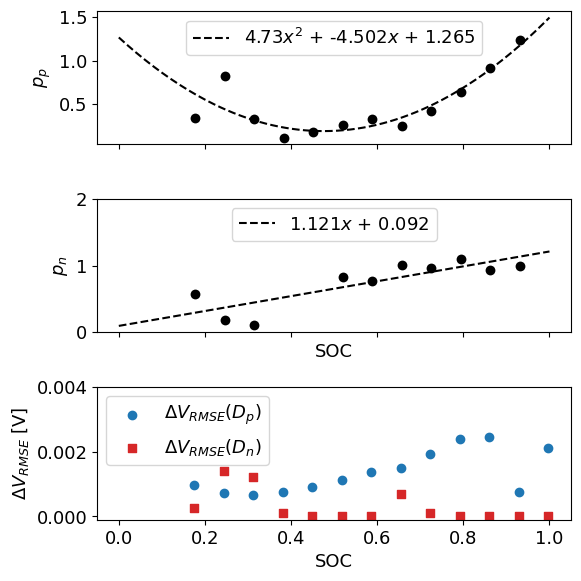

In [55]:
%matplotlib inline
# load values
Ds = Ds0.copy()
Ds = Ds0[(Ds0.e<0.1)]
# Ds.kn[Ds0.kn>5] =1
# Ds.kp[Ds0.kp>5] =1
# Ds = Ds0.loc[(Ds0.kn<5) & (Ds0.kp<5)]

# polyfit data
# pp = np.polyfit(Ds.SOC.loc[(Ds.kp<9) & (Ds.kp>0.1) & (Ds0.e<0.1) & (Ds0.e>0.0001)], Ds.kp.loc[(Ds.kp<9) & (Ds.kp>0.1) & (Ds0.e<0.1) & (Ds0.e>0.0001)],2) 
# pn = np.polyfit(Ds.SOC.loc[(Ds.kn<9) & (Ds.kn>0.1)& (Ds0.e<0.1) & (Ds0.e>0.0001)], Ds.kn.loc[(Ds.kn<9) & (Ds.kn>0.1)& (Ds0.e<0.1) & (Ds0.e>0.0001) ],1) 
pp = np.polyfit(Ds.SOC, Ds.kp,2) 
pn = np.polyfit(Ds.SOC.loc[(Ds.kn<9)], Ds.kn.loc[(Ds.kn<9)],1) 
# pn = np.polyfit(Ds.SOC, Ds.kn,1) 
x = np.linspace(0,1,200)
yp = np.polyval(pp,x)
yn = np.polyval(pn,x)

# plot fits
fig, ax = plt.subplots(3,1, figsize=(6,6), sharex=True)
ax = ax.flatten()

ax[0].scatter(Ds.SOC, Ds.kp, color = 'lightgrey')
ax[0].scatter(Ds.SOC.loc[(Ds.kp<9) & (Ds.kp>0.1) & (Ds0.e<0.1) & (Ds0.e>0.0001)], Ds.kp.loc[(Ds.kp<9) & (Ds.kp>0.1) & (Ds0.e<0.1) & (Ds0.e>0.0001)], color = 'k')
ax[0].plot(x, yp, color = 'k', label = polystr(pp) , linestyle = '--')#,
ax[0].set_ylabel('$p_p$')
ax[0].legend(loc = "upper center", prop={'size': 13})
# ax[0].set_ylim([0,2])
ax[1].scatter(Ds.SOC, Ds.kn , color = 'lightgrey') 
# ax[1].scatter(Ds.SOC.loc[(Ds.kn<9) & (Ds.kn>0.1) & (Ds0.e<0.1) & (Ds0.e>0.0001)], Ds.kn.loc[(Ds.kn<9) & (Ds.kn>0.1) & (Ds0.e<0.1) & (Ds0.e>0.0001)] , color = 'k') 
ax[1].scatter(Ds.SOC.loc[(Ds.kn<9)], Ds.kn.loc[(Ds.kn<9)], color = 'k') 

ax[1].plot(x, yn, color = 'k', label = polystr(pn), linestyle = '--')#
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$p_n$')
ax[1].set_ylim([0,2])
ax[1].legend(loc = "upper center", prop={'size': 13})

color = 'tab:blue'
x = list(sensitivity_rmses.SOC)
ax[2].set_xlabel('SOC')
ax[2].set_ylabel("$\Delta V_{RMSE}$ [V]")
ax[2].scatter(x, sensitivity_rmses['delta_rmses_V_Dp'], color=color, label = "$\Delta V_{RMSE}(D_p)$")
# ax1.tick_params(axis='y', labelcolor=color)
color = 'tab:red'
ax[2].scatter(x, sensitivity_rmses['delta_rmses_V_Dn'], color=color, marker = "s", label = "$\Delta V_{RMSE}(D_n)$")
ax[2].legend(ncol=1, loc ="upper left")
ax[2].set_ylim([-0.0001,0.004])

plt.rcParams.update({'font.size': 13})
plt.tight_layout()
plt.savefig('./fast_discharge/figs/Ds_p_sensitivity.eps', format='eps')
plt.show()

In [ ]:
%matplotlib widget


## Fit all pulses (sequentially, p-n)

In [ ]:
Dp_0 = 8.0E-15
Dn_0 = 8.0E-14
lb = np.array([1e-1]*2)
ub =  np.array([1e1]*2)
k_list = []                               
SOC_list = []
e_list = []
models = []
for c,(i,j) in enumerate(zip(i2[0:-1],i2[1::])):
    print(c)
    # define pulse data
    pulse = data[i:j].copy()
    pulse.t = pulse.t-pulse.t.iloc[0]

    # define sim parameters
    SOC_0 = pulse.SOC.iloc[0]
    pulse_current = pulse[['t','I']].to_numpy()

    # define model 
    if c==0:
        model = pybamm.lithium_ion.SPMe()
        # k0 = np.array([SOC_0])
    else:
        model.set_initial_conditions_from(solution, inplace=True)
        # k0 = np.array([kp.x[0]])
    models.append(model)
    
    # Fit D
    # if SOC_0 < 0:
    k0 = np.array([SOC_0])
    loss_function = simulate_pulse
    kp = dfols.solve(simulate_pulse_pos, k0, args=(np.array([1])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg
    kn = dfols.solve(simulate_pulse_neg, k0, args=(np.array([kp.x[0]])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg

    k = np.array([kp.x[0], kn.x[0]])
    e = loss_function(k)

    # # retry high errors
    # # tries = 0
    # if (e > 0.05):
    #     print("restart")
    #     k0 = np.array([SOC_0])
    #     kp = dfols.solve(simulate_pulse_pos, k0, args=(np.array([1])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg
    #     kn = dfols.solve(simulate_pulse_neg, k0, args=(np.array([kp.x[0]])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg
    #     k = np.array([kp.x[0], 1])    
    #     e = loss_function(k)
    #     # tries = tries + 1


    # # pulse = pulse[pulse.I>0]
    # # pulse_current = pulse[['t','I']].to_numpy()
    # kn = dfols.solve(simulate_pulse_neg, np.array([SOC_0]), args=(np.array([kp.x[0]])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg

    k_list.append(k)
    SOC_list.append(pulse.SOC.iloc[-1])  
    e_list.append(e)

    # simulate with k
    solutions = []
    # nominal
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0,
        "Negative electrode diffusivity [m2.s-1]": Dn_0,
        })
    sim0 = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution0 = sim0.solve( initial_soc=SOC_0)
    solutions.append(solution0)
    
    # fitted
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*k_list[c][0],
        "Negative electrode diffusivity [m2.s-1]": Dn_0*k_list[c][1],
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve( initial_soc=SOC_0)
    solutions.append(solution)

    # plot with 
    plot_pulse(pulse,solutions)


In [ ]:
# save parameters and soc 
Ds = pd.DataFrame(columns=('SOC', 'kp','kn','e'))
for i,(k, soc, e) in enumerate(zip(k_list, SOC_list, e_list)):
   if  (k[0]) and (k[1]):
      Ds.loc[i] = [soc, k[0], k[1], e[0]]

display(Ds)
Ds.to_csv('./fast_discharge/Ds_continuous_rmseV_SOC0.csv')

,SOC,kp,kn,e
0,0.931499,1.447024,0.100000,0.012482
1,0.862995,1.153524,0.194262,0.009410
2,0.794493,0.870020,0.510020,0.011548
3,0.725995,0.591518,3.616518,0.011344
4,0.657494,0.373020,10.000000,0.014997
5,0.588994,0.769518,2.024518,0.007171
6,0.520495,0.496019,10.000000,0.007641
7,0.451993,0.307520,10.000000,0.007952
8,0.383496,0.179018,10.000000,0.011250
9,0.314995,0.140000,1.650521,0.013256


## Fit all pulses based on sensitivity

In [ ]:
Dp_0 = 8.0E-15
Dn_0 = 8.0E-14
lb = np.array([1e-1]*2)
ub =  np.array([1e1]*2)
k_list = []                               
SOC_list = []
e_list = []
models = []
for c,(i,j) in enumerate(zip(i2[0:-1],i2[1::])):
    print(c)
    # define pulse data
    pulse = data[i:j].copy()
    pulse.t = pulse.t-pulse.t.iloc[0]

    # define sim parameters
    SOC_0 = pulse.SOC.iloc[0]
    pulse_current = pulse[['t','I']].to_numpy()

    # define model 
    # if c==0:
    model = pybamm.lithium_ion.SPMe()
        # k0 = np.array([SOC_0])
    # else:
        # model.set_initial_conditions_from(solution, inplace=True)
        # k0 = np.array([kp.x[0]])
    models.append(model)
    
    # Fit D
    loss_function = simulate_pulse
    k0 = np.array([1])
    if sensitivity_rmses.diff_rmses_V_D.loc[c]>0:
        kp = dfols.solve(simulate_pulse_pos, k0, args=(np.array([1])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg
        kn = dfols.solve(simulate_pulse_neg, k0, args=(np.array([kp.x[0]])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg
    else:
        kn = dfols.solve(simulate_pulse_neg, k0, args=(np.array([1])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg
        kp = dfols.solve(simulate_pulse_pos, k0, args=(np.array([kn.x[0]])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg

    k = np.array([kp.x[0], kn.x[0]])
    e = loss_function(k)

    # retry high errors
    # tries = 0
    # if (e > 0.05):
    #     print(tries)
    #     k0 = np.array([SOC_0])
    #     if sensitivity_rmses.diff_rmses_V_D.loc[c]>0:
    #         kp = dfols.solve(simulate_pulse_pos, k0, args=(np.array([1])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg
    #         kn = dfols.solve(simulate_pulse_neg, k0, args=(np.array([kp.x[0]])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg
    #     else:
    #         kn = dfols.solve(simulate_pulse_neg, k0, args=(np.array([1])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg
    #         kp = dfols.solve(simulate_pulse_pos, k0, args=(np.array([kn.x[0]])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg        k = np.array([kp.x[0], 1])    
    #     e = loss_function(k)
    #     # tries = tries + 1


    # # pulse = pulse[pulse.I>0]
    # # pulse_current = pulse[['t','I']].to_numpy()
    # kn = dfols.solve(simulate_pulse_neg, np.array([SOC_0]), args=(np.array([kp.x[0]])), bounds = (np.array([lb[0]]),np.array([ub[0]])), rhoend=1e-2) # fix pos, fit neg

    k_list.append(k)
    SOC_list.append(pulse.SOC.iloc[-1])  
    e_list.append(e)

    # simulate with k
    solutions = []
    # nominal
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0,
        "Negative electrode diffusivity [m2.s-1]": Dn_0,
        })
    sim0 = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution0 = sim0.solve( initial_soc=SOC_0)
    solutions.append(solution0)
    
    # fitted
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*k_list[c][0],
        "Negative electrode diffusivity [m2.s-1]": Dn_0*k_list[c][1],
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve( initial_soc=SOC_0)
    solutions.append(solution)

    # plot with 
    plot_pulse(pulse,solutions)


In [ ]:
# save parameters and soc 
Ds = pd.DataFrame(columns=('SOC', 'kp','kn','e'))
for i,(k, soc, e) in enumerate(zip(k_list, SOC_list, e_list)):
   if  (k[0]) and (k[1]):
      Ds.loc[i] = [soc, k[0], k[1], e[0]]

display(Ds)
Ds.to_csv('./fast_discharge/Ds_sensitivity_restart_SPM_rmseV.csv')

## Curve fitting

[ 4.94942499 -4.78299642  1.41632865]
[-4.39276267  7.20486739]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


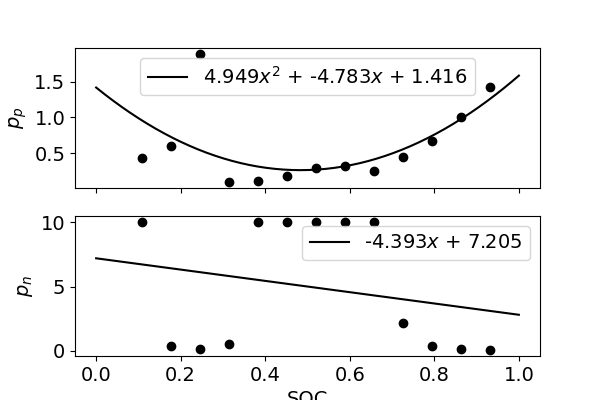

In [17]:
def monoExp(x, a, b):
    return a*(x)**b


# load values
Ds = Ds0.iloc[0::]
# Ds = Ds0[Ds0.e<0.009]

# polyfit data
pp = np.polyfit(Ds.SOC, Ds.kp,2) # low soc
pn = np.polyfit(Ds.SOC, Ds.kn,1) # low soc
x = np.linspace(0,1,200)
yp = np.polyval(pp,x)
yn = np.polyval(pn,x)
# p0 = (1,0.5)
# params, cv = curve_fit(monoExp, Ds.SOC, Ds.kn, p0)
# a,b = params
# yn= a*(x+0.03)**b

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Ds.SOC, Ds.kp, color = 'k')
ax[0].plot(x, yp, label = polystr(pp) , color = 'k')
ax[0].set_ylabel('$p_p$')
ax[0].legend()
# ax[0].set_ylim([0,2])
ax[1].scatter(Ds.SOC, Ds.kn , color = 'k')
ax[1].plot(x, yn, label = polystr(pn), color = 'k')
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$p_n$')
# ax[1].set_ylim([0,2])
ax[1].legend()

# display(Ds)

print(pp)
print(pn)# Ds.loc[len(Ds.index)] = [0, np.nan, Ds.kn.iloc[-1], np.nan] 

plt.savefig('./fast_discharge/figs/p.eps', format='eps')


[ 5.32189152 -5.72319492  1.7780767 ]
[-0.65600518  0.5899654   0.15770689]


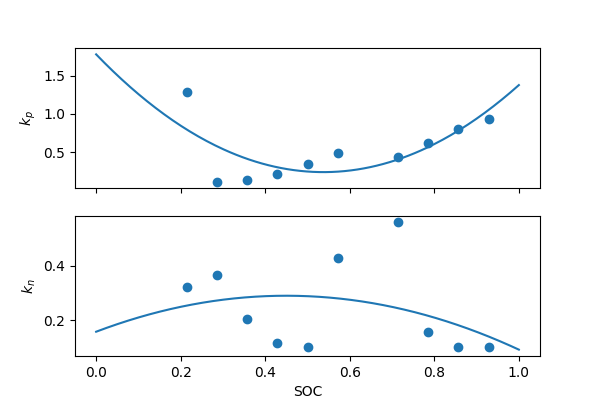

In [8]:
# load values
Ds0 = pd.read_csv('./fast_discharge/Ds13.csv', usecols=range(1,5))
Ds = Ds0[Ds0.e<0.008]

# polyfit data

pp = np.polyfit(Ds.SOC, Ds.kp,2) # low soc
pn = np.polyfit(Ds.SOC, Ds.kn,2) # low soc
x = np.linspace(0,1,200)
yp = np.polyval(pp,x)
yn = np.polyval(pn,x)

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Ds.SOC, Ds.kp)
ax[0].plot(x, yp)
ax[0].set_ylabel('$k_p$')
# ax[0].set_ylim([0,2])
ax[1].scatter(Ds.SOC, Ds.kn)
ax[1].plot(x, yn)
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$k_n$')
# ax[1].set_ylim([0,2])

# display(Ds)

print(pp)
print(pn)

In [ ]:
Ds

,SOC,kp,kn,e
1,0.857179,0.792933,1.155362,0.003367
2,0.785771,0.624047,1.273074,0.002276
3,0.714363,0.443500,1.397708,0.002052
4,0.642953,0.270809,1.397544,0.004815
5,0.571544,0.431176,1.387164,0.003244
6,0.500135,0.351810,1.522016,0.002597
7,0.428726,0.217888,1.522144,0.004088
8,0.357318,0.151866,0.162605,0.003504
9,0.285910,0.125638,0.313552,0.004312


[ 2.29468003 -1.19740116]
[ 2.45793142 -0.82752889  0.12563191]
[1.00000237 0.07140758]
[0.99999824 0.07140902]


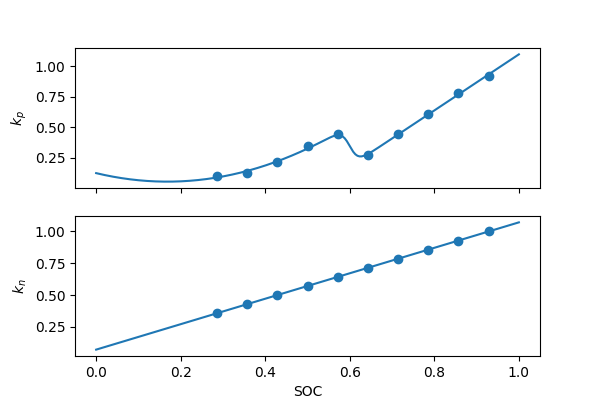

In [212]:
# load values
Ds0 = pd.read_csv('./fast_discharge/Ds12.csv', usecols=range(1,5))
Ds = Ds0[Ds0.e<0.008]
# polyfit data

pp_high = np.polyfit(Ds.SOC[0:5], Ds.kp[0:5],1) # high soc
pp_low = np.polyfit(Ds.SOC[5::], Ds.kp[5::],2) # low soc
pn_high = np.polyfit(Ds.SOC[Ds.SOC>0.4], Ds.kn[Ds.SOC>0.4],1) # high soc
pn_low = np.polyfit(Ds.SOC[Ds.SOC<0.4], Ds.kn[Ds.SOC<0.4],1) # low soc
x = np.linspace(0,1,200)
yp = np.polyval(pp_high,x)*(1/(1 + np.exp(-(x-0.6)*100)))+ np.polyval(pp_low,x)*(1-1/(1 + np.exp(((0.6-x)*100))))
yn = np.polyval(pn_high,x)*(1/(1 + np.exp(-(x-0.4)*20)))+ np.polyval(pn_low,x)*(1-1/(1 + np.exp(((0.4-x)*20))))
# yn = np.polyval(pn1,x) + np.polyval(pn2,x)

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Ds.SOC, Ds.kp)
ax[0].plot(x, yp)
ax[0].set_ylabel('$k_p$')
# ax[0].set_ylim([0,2])
ax[1].scatter(Ds.SOC, Ds.kn)
ax[1].plot(x, yn)
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$k_n$')
# ax[1].set_ylim([0,2])

# display(Ds)

print(pp_high)
print(pp_low)
print(pn_high)
print(pn_low)

In [ ]:
Ds

,SOC,kp,kn
0,0.928590,0.942659,0.915940
1,0.857179,0.778717,0.996159
2,0.785771,0.625759,1.106700
3,0.714363,0.433340,1.101692
4,0.642953,0.269941,0.928569
5,0.571544,0.454229,0.971036
6,0.500135,0.359006,0.997634
7,0.428726,0.210167,1.193241
8,0.357318,0.125000,0.285557
9,0.285910,0.100000,0.572866


0


2023-04-14 13:24:40.700 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:24:41.230 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


1


2023-04-14 13:24:44.531 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:24:45.237 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


2


2023-04-14 13:24:48.733 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:24:49.208 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


3


2023-04-14 13:24:52.488 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:24:53.078 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


4


2023-04-14 13:24:57.234 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:24:57.942 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


5


2023-04-14 13:25:02.122 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:25:02.761 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


6


2023-04-14 13:25:06.648 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:25:07.297 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


7


2023-04-14 13:25:10.753 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:25:11.494 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


8


2023-04-14 13:25:17.285 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:25:17.976 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


9


2023-04-14 13:25:21.285 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-04-14 13:25:21.937 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


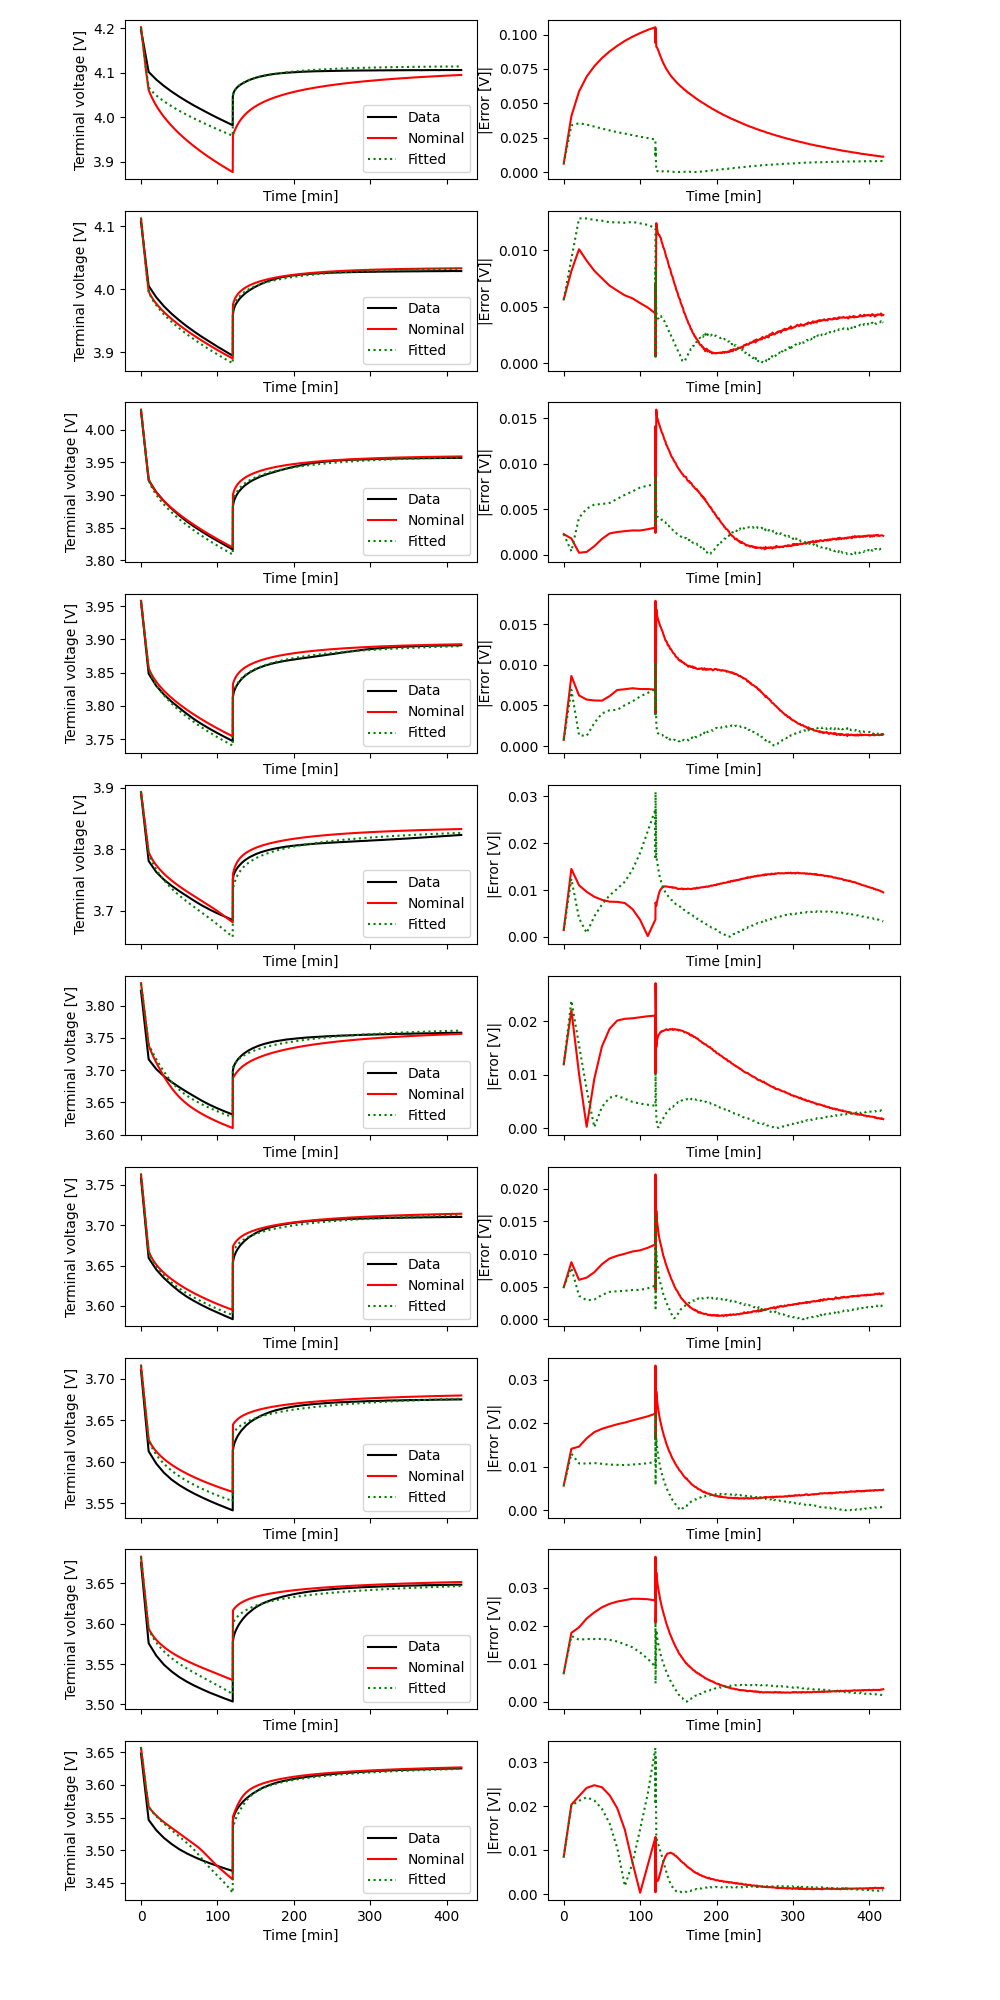

In [213]:
%matplotlib widget
fig, ax = plt.subplots(len(Ds), 2, figsize=(10,len(Ds)*2), sharex=True)
# ax = ax.flatten()

Dp_0 = 8.0E-15
Dn_0 = 8.0E-14

for k, (i,j) in enumerate(zip(i2[0:len(Ds)],i2[1::])):
    print(k)

    # define pulse data
    pulse = data[i:j].copy()
    pulse.t = pulse.t-pulse.t.iloc[0]

    # define sim parameters
    SOC_0 = pulse.SOC.iloc[0]
    pulse_current = pulse[['t','I']].to_numpy()

    # simulate with k
    solutions = []
    # nominal
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0,
        "Negative electrode diffusivity [m2.s-1]": Dn_0,
        })
    sim0 = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution0 = sim.solve( initial_soc=SOC_0)
    solutions.append(solution0)
    
    # fitted
    param.update({
        "Positive electrode diffusivity [m2.s-1]": Dp_0*Ds.iloc[k].kp,
        "Negative electrode diffusivity [m2.s-1]": Dn_0*Ds.iloc[k].kn,
        })
    sim = pybamm.Simulation(model, experiment=experiment, parameter_values = param)
    solution = sim.solve( initial_soc=SOC_0)
    solutions.append(solution)

    # plot with 
    ax[k,0].plot(pulse.t, pulse.V, color = 'k')
    ax[k,0].set_xlabel(xlabel)
    ax[k,0].set_ylabel('Terminal voltage [V]')
    
    colors = ['r','g']
    linestyles = ['-', ':']
    for j,solution in enumerate(solutions):
        t = solution["Time [s]"].entries
        V = solution['Terminal voltage [V]']
        ax[k,0].plot(t, V(t), color = colors[j], linestyle = linestyles[j])
        ax[k,0].legend(["Data", "Nominal", "Fitted"])

        e_V = abs(pulse.V - V(pulse.t))
        ax[k,1].plot(pulse.t, e_V, color = colors[j], linestyle = linestyles[j])
        ax[k,1].set_xlabel(xlabel)
        ax[k,1].set_ylabel('|Error [V]|')

plt.subplots_adjust(bottom=0.05, top=0.99)
        
    

## Curve fit concentration dependence (OReagan's form)

In [142]:
def Dsp_c(soc,a1,a2,a3,b1,b2,b3,c0,c1,c2,c3,c):
    # sto = (1-soc)*(1-y0)+0.353
    sto = (1-soc)*(0.837-0.034)+0.034
    # sto = 0.837-soc*(0.837-0.034)
    # soc = (0.837-sto)/(0.837-0.034)

    D_ref = (
            10
            ** (
                c0
                + a1 * np.exp(-((sto - b1) ** 2) / c1)
                + a2 * np.exp(-((sto - b2) ** 2) / c2)
                + a3 * np.exp(-((sto - b3) ** 2) / c3)
            )
            # *0.3672467477  # correcting factor (see O'Regan et al 2021)
            *c
        )

    return D_ref


def Dsn_c(sto,a1,a2,a3,b1,b2,b3,c0,c1,c2,c3,c):
    D_ref = (
            10
            ** (
                c0
                + a1 * np.exp(-((sto - b1) ** 2) / c1)
                + a2 * np.exp(-((sto - b2) ** 2) / c2)
                + a3 * np.exp(-((sto - b3) ** 2) / c3)
                # + a4 * np.exp(-((sto - b4) ** 2) / c4)

            )
            * c
        )

    return D_ref

[-4.75533191e-01 -1.02806727e+00 -8.28210929e-01  3.35919225e-01
  5.63142410e-01  8.30800724e-01 -1.38158037e+01  2.50322794e-02
  7.15484951e-03  1.65275022e-03  5.48265942e-01]


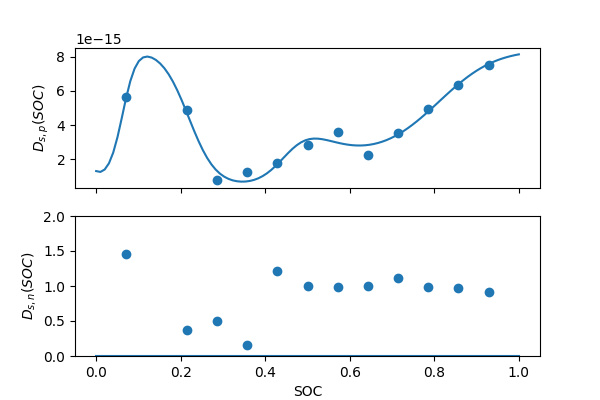

In [ ]:
# load values
Ds0 = pd.read_csv('./fast_discharge/Ds10.csv', usecols=range(1,5))
Ds = Ds0[Ds0.e<0.01]
Ds['Ds_p'] = Dp_0*Ds.kp
Ds['Ds_n'] = Dp_0*Ds.kn


# find curve fit parameters
# p0_p = [-0.9231, -0.4066,-0.993,0.3216,0.4532,0.8098,-13.96,0.002534,0.003926,0.09924,0.4]
p0_p = [-0.9231, -0.4066,-0.993,0.3216,0.4532,0.8098,-13.96,0.002534,0.003926,0.09924,0.4]
pp, covariance = curve_fit(Dsp_c, Ds.SOC, Ds.Ds_p, p0 = p0_p)
# p0_n = [11.17,-1.553,-6.136, -9.725,1.85,0.2031,0.5375,0.9144, 0.5953,-15.11,0.0006091,0.06438,0.0578,0.001356,2092]
p0_n = [-1.553,-6.136, -9.725,0.2031,0.5375,0.9144, -15.11,0.0006091,0.06438,0.0578,3.0321]
pn, covariance = curve_fit(Dsn_c, Ds.SOC, Ds.Ds_n, p0 = pp*10)

# calculate fitted values
x = np.linspace(0,1,100)
yp = Dsp_c(x,*pp)
yn = Dsn_c(x,*pn)

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Ds.SOC, Ds.Ds_p)
ax[0].plot(x, yp)
ax[0].set_ylabel('$D_{s,p}(SOC)$')
ax[1].scatter(Ds.SOC, Ds.kn)
ax[1].plot(x, yn)
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$D_{s,n}(SOC)$')
ax[1].set_ylim([0,2])

# display(Ds)

print(pp)
# print(pn)

## Curve fit concnetration dependent diffusion from literature

In [111]:
Dn = pd.read_csv('./fast_discharge/Levi Aurbach 1997 graphite diffusion.csv', header=None)
df_labels = ['SOC', 'Dn']
Dn.set_axis(df_labels, axis=1, inplace=True)
Dn.Dn = Dn.Dn
# display(Dn0)

Dp = pd.read_csv('./fast_discharge/Wu 2012 NMC diffusion.csv', header=None)
df_labels = ['SOC', 'Dp']
Dp.set_axis(df_labels, axis=1, inplace=True)
# display(Dp0)


C:\Users\Vivian\AppData\Local\Temp\ipykernel_21372\4208541996.py:3: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  Dn.set_axis(df_labels, axis=1, inplace=True)
C:\Users\Vivian\AppData\Local\Temp\ipykernel_21372\4208541996.py:9: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  Dp.set_axis(df_labels, axis=1, inplace=True)


In [293]:
def Dsp_c(soc,a1,a2,a3,b1,b2,b3,c0,c1,c2,c3,c):
    # sto = (1-soc)*(1-y0)+0.353
    # sto = (1-soc)*(0.837-0.034)+0.034
    # sto = 0.837-soc*(0.837-0.034)
    # soc = (0.837-sto)/(0.837-0.034)
    sto = (1-soc)*(1-0.034)+0.034
    # sto = soc
    D_ref = (
            10
            ** (
                c0
                + a1 * np.exp(-((sto - b1)/ c1)** 2 )
                + a2 * np.exp(-((sto - b2)/ c2)** 2 )
                + a3 * np.exp(-((sto - b3)/ c3)** 2 )
            )
            *c
            # *0.3672467477  # correcting factor (see O'Regan et al 2021)
        )

    return D_ref

def monoExp(x, a, b):
    return a*(x)**b


[4.72456394e-14 1.78059902e+00]


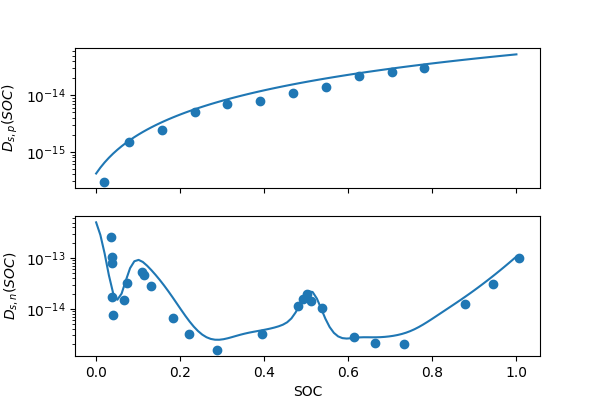

In [267]:
# calculate fitted values
x = np.linspace(0,1,100)
yn = 10**(
    -5.9401e-1*np.exp(-((x-2.5720e-1)/8.4006e-2)**2)\
    +5.1118e-1*np.exp(-((x-5.1715e-1)/1.0308e-1)**2)\
    -6.6628e-2*np.exp(-((x-7.5004e-1)/6.0470e-2)**2)\
    -1.9021e-1*np.exp(-((x-5.7634e-1)/4.1183e-2)**2)\
    +5.7993e-1*np.exp(-((x-5.0993e-1)/3.2647e-2)**2)\
    -1.0736e1*np.exp(-((x-5.5128e-1)/1.0588)**2)\
    -1.2463*np.exp(-((x-4.7459e-2)/3.0551e-2)**2)\
    -4
)

p0 = (1e-14,0.5)
params, cv = curve_fit(monoExp, Dp.SOC, Dp.Dp, p0)
a,b = params
yp = a*(x+0.07)**b
# y = (1-x)
# yp = 10**(
#     -1.3922e12*np.exp(-((y-4.0704)/5.8343e-1)**2)\
#     -1.4516e1*np.exp(-((y-1.0490)/1.8016)**2)\
#     -8.6982e-1*np.exp(-((y-3.0124e-1)/2.1998e-1)**2)\
#     # -8.6982e-1*np.exp(-((y-3.0124e-1)/2.1998e-1)**2)\

# )

# p0_p = [-1.3922e12, -1.4516e1,-8.6982e-1,4.0704,1.0490,3.0124e-1,0,5.8343e-1,1.8016,2.1998e-1,1]
# pp, covariance = curve_fit(Dsp_c, Dp.SOC, Dp.Dp, p0 = p0_p)
# yp = Dsp_c(x,*pp)

# pp = np.polyfit(Dp.SOC, np.log(Dp.Dp), 1)
# a = np.exp(pp[1])
# b = pp[0]
# yp = a * np.exp(b * x)

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Dp.SOC, Dp.Dp)
ax[0].semilogy(x, yp)
ax[0].set_ylabel('$D_{s,p}(SOC)$')


ax[1].scatter(Dn.SOC, Dn.Dn)
ax[1].semilogy(x, yn)
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$D_{s,n}(SOC)$')
# ax[1].set_ylim([0,2])

# display(Ds)

print(params)
# print(pn)

In [256]:
yp[0]

2.279024502808816e-16

[  5.10131478 -34.67348865]


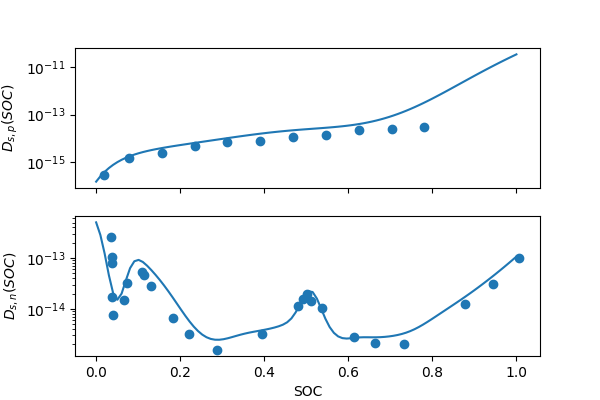

In [227]:
# calculate fitted values
x = np.linspace(0,1,100)
yn = 10**(
    -5.9401e-1*np.exp(-((x-2.5720e-1)/8.4006e-2)**2)\
    +5.1118e-1*np.exp(-((x-5.1715e-1)/1.0308e-1)**2)\
    -6.6628e-2*np.exp(-((x-7.5004e-1)/6.0470e-2)**2)\
    -1.9021e-1*np.exp(-((x-5.7634e-1)/4.1183e-2)**2)\
    +5.7993e-1*np.exp(-((x-5.0993e-1)/3.2647e-2)**2)\
    -1.0736e1*np.exp(-((x-5.5128e-1)/1.0588)**2)\
    -1.2463*np.exp(-((x-4.7459e-2)/3.0551e-2)**2)\
    -4
)

y = (1-x)
yp = 10**(
    -1.3922e12*np.exp(-((y-4.0704)/5.8343e-1)**2)\
    -1.4516e1*np.exp(-((y-1.0490)/1.8016)**2)\
    -8.6982e-1*np.exp(-((y-3.0124e-1)/2.1998e-1)**2)\
)

# plot fits
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex=True)
ax = ax.flatten()

ax[0].scatter(Dp.SOC, Dp.Dp)
ax[0].semilogy(x, yp)
ax[0].set_ylabel('$D_{s,p}(SOC)$')


ax[1].scatter(Dn.SOC, Dn.Dn)
ax[1].semilogy(x, yn)
ax[1].set_xlabel('SOC')
ax[1].set_ylabel('$D_{s,n}(SOC)$')
# ax[1].set_ylim([0,2])

# display(Ds)

print(pp)
# print(pn)